In [23]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
#import project modules
from stock_prediction_modules import *

Ex-Dividend: [  0.        567.9716685] 

Split Ratio: [1] 

Ex-Dividend's sum: 567.9716685 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3125 non-null   object 
 1   Open         3125 non-null   float64
 2   High         3125 non-null   float64
 3   Low          3125 non-null   float64
 4   Close        3125 non-null   float64
 5   Volume       3125 non-null   int64  
 6   Ex-Dividend  3125 non-null   float64
 7   Split Ratio  3125 non-null   int64  
 8   Adj. Open    3125 non-null   float64
 9   Adj. High    3125 non-null   float64
 10  Adj. Low     3125 non-null   float64
 11  Adj. Close   3125 non-null   float64
 12  Adj. Volume  3125 non-null   int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 317.5+ KB


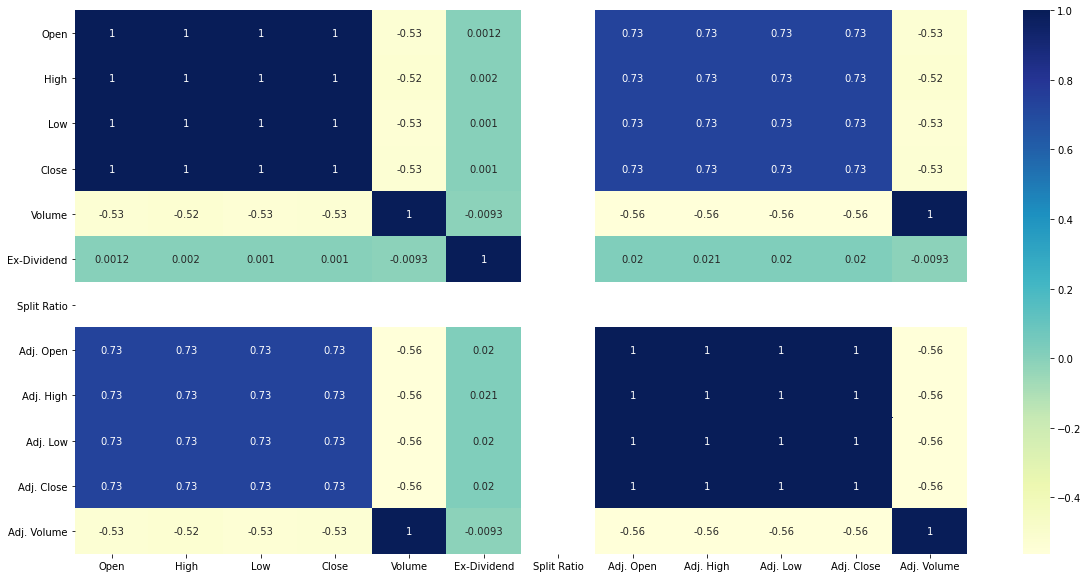

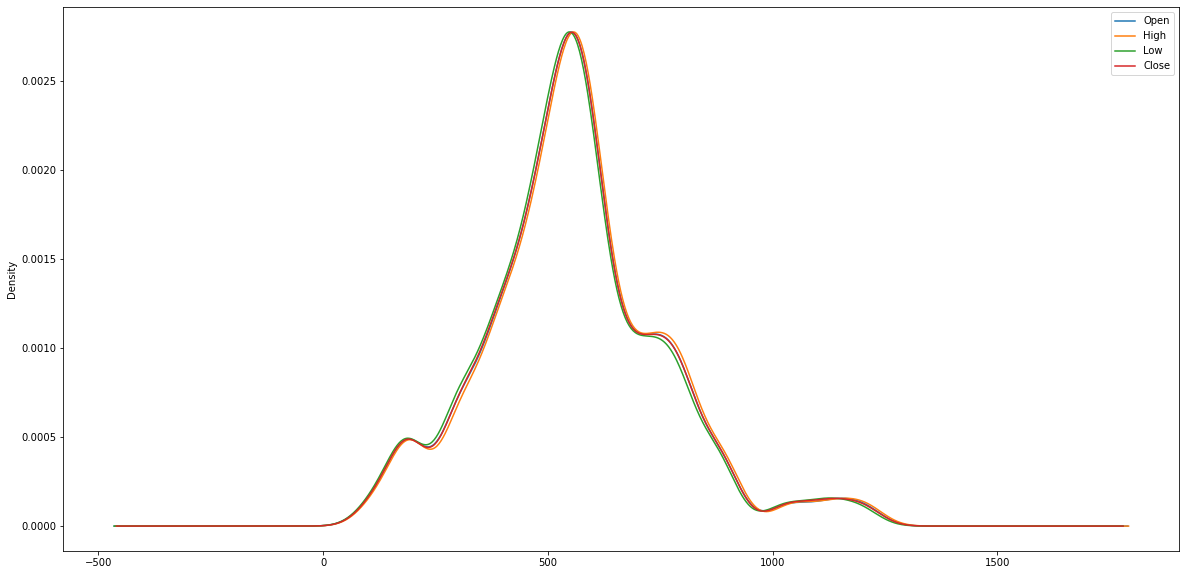

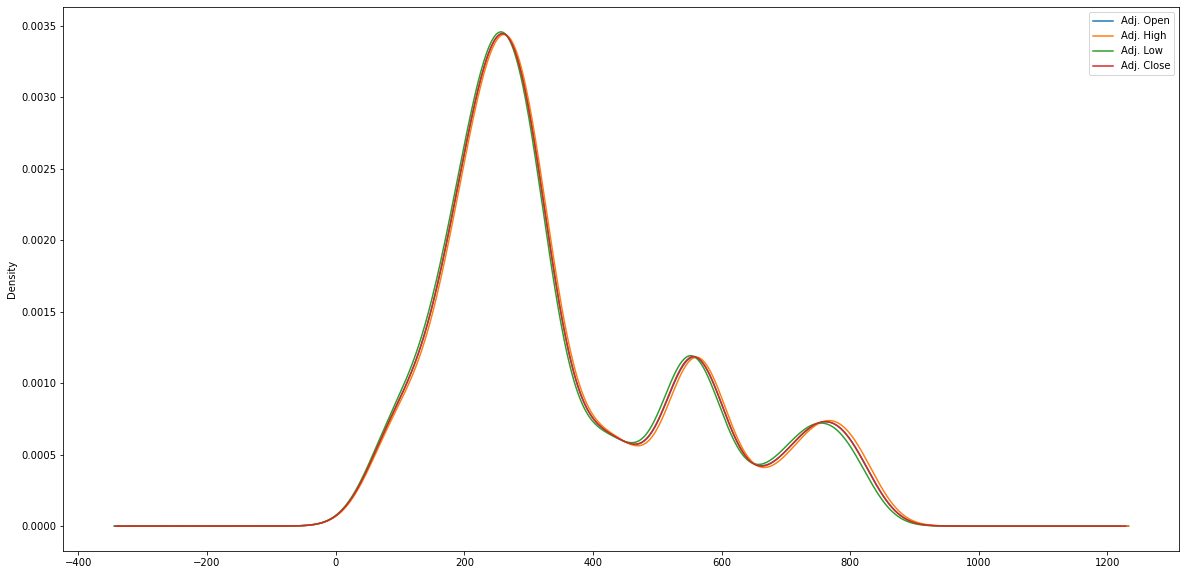

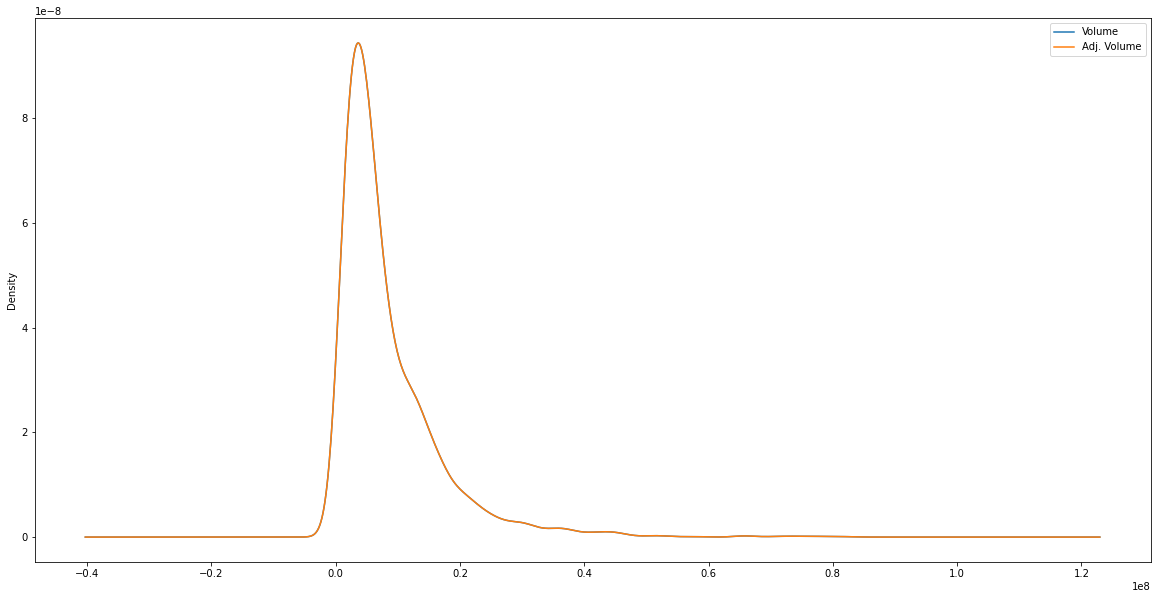

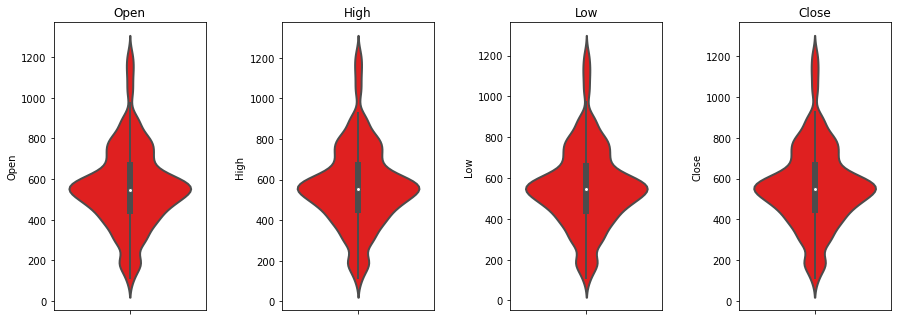

KeyboardInterrupt: 

In [24]:
stock_market_dataset = plot_all_graphs('Google.csv')

In [7]:
normalized_array, normalized_df, normalizer = normalize_dataset(stock_market_dataset)
normalized_df.head()
n = normalized_df.shape[0]

In [8]:
num_features = 6 
close_value_col_index = 3
#creating training set with time steps.

time_step=30    #1 month time step
train_per = 0.7
val_per = 0.2
test_per = 1-(train_per+val_per)  #0.1
    
X_train, y_train, X_val, y_val, X_test, y_test =  make_train_test_val_sets(normalized_array, num_features, close_value_col_index, time_step, train_per, val_per, test_per)

print(str(X_train.shape)+ " training dataset shape")
print(str(X_val.shape)+ "  val dataset shape")
print(str(X_test.shape)+ "  test dataset shape")

(3095, 30, 6)
(2187, 30, 6) training dataset shape
(625, 30, 6)  val dataset shape
(283, 30, 6)  test dataset shape


In [9]:
#Implementing LSTM
model = keras.models.Sequential()         #initializing network

#input layer
hidden_layer_units = 10
model.add(keras.layers.LSTM(hidden_layer_units,kernel_regularizer=L1L2(0.0001), return_sequences=True, input_shape=(X_train.shape[1],num_features)))

#LSTM layer 2
hidden_layer_units = 10
model.add(keras.layers.LSTM(hidden_layer_units,kernel_regularizer=L1L2(0.0001)))

#Output layer
output_layer_units = 1     #just need the close value
model.add(keras.layers.Dense(output_layer_units))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 70, batch_size = 10)

Epoch 1/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0145
Epoch 2/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0063
Epoch 3/70
219/219 [==============================] - 4s 18ms/step - loss: 0.0044
Epoch 4/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0034
Epoch 5/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0028
Epoch 6/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0024
Epoch 7/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0021
Epoch 8/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0019
Epoch 9/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0017
Epoch 10/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0016
Epoch 11/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0014
Epoch 12/70
219/219 [==============================] - 4s 17ms/step - loss: 0.0013
Epoch 13/70
2

In [16]:
real_close_value = normalized_df.iloc[ time_step: , close_value_col_index:close_value_col_index+1].values    
print(real_close_value.shape)

predicted_close_value_train, predicted_close_value_val, predicted_close_value_test, combined_prediction = get_predictions(model, X_train, X_val, X_test)
print(combined_prediction.shape)

(3095, 1)
(3095,)


In [17]:
#inverse normalize predicted close values
denormalized_df = denormalize_data(normalized_df, normalizer, time_step, combined_prediction, close_value_col_index)

In [12]:
predicted_close_value = denormalized_df.iloc[ : ,close_value_col_index:close_value_col_index+1]
denormalized_df.head(5)

,0,1,2,3,4,5
0,130.800,134.24,128.90,122.947680,15124800.0,0.0
1,135.275,136.87,134.03,125.088171,13022700.0,0.0
2,134.660,138.53,132.24,127.452221,14973200.0,0.0
3,137.670,138.45,136.00,129.745546,13381400.0,0.0
4,136.560,139.88,136.55,131.781320,14115000.0,0.0


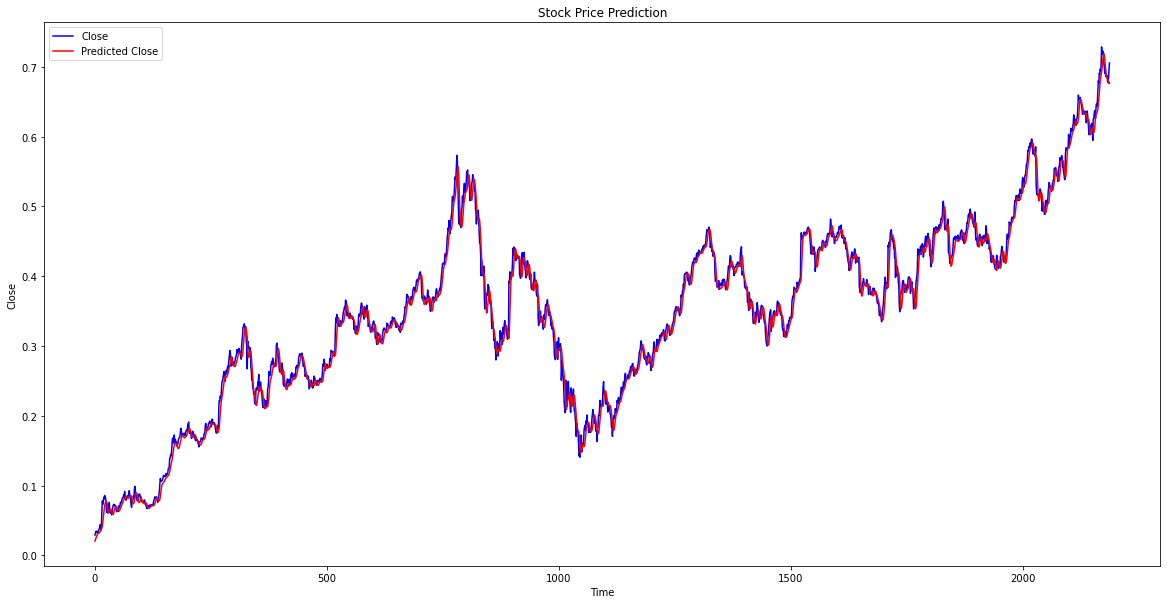

In [13]:
#Training set actual vs prediction
real_close_value_train = normalized_df.iloc[ time_step:int(n*train_per)+time_step , close_value_col_index:close_value_col_index+1].values
plot_versus_graph(real_close_value_train, 'blue', 'Close', predicted_close_value_train, 'red', 'Predicted Close')

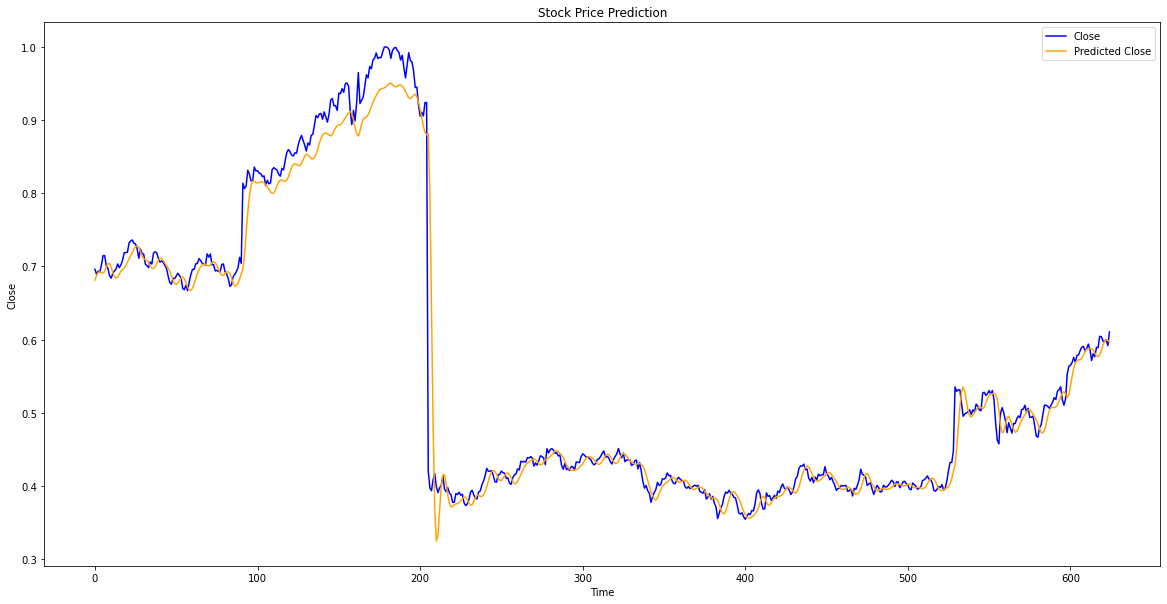

In [14]:
#Cross Val set actual vs predicted
#int(n*0.7)+time_step
real_close_value_val = normalized_df.iloc[ int(n*0.7)+time_step:int(n*0.9)+time_step , close_value_col_index:close_value_col_index+1].values
plot_versus_graph(real_close_value_val, 'blue', 'Close', predicted_close_value_val, 'orange', 'Predicted Close')

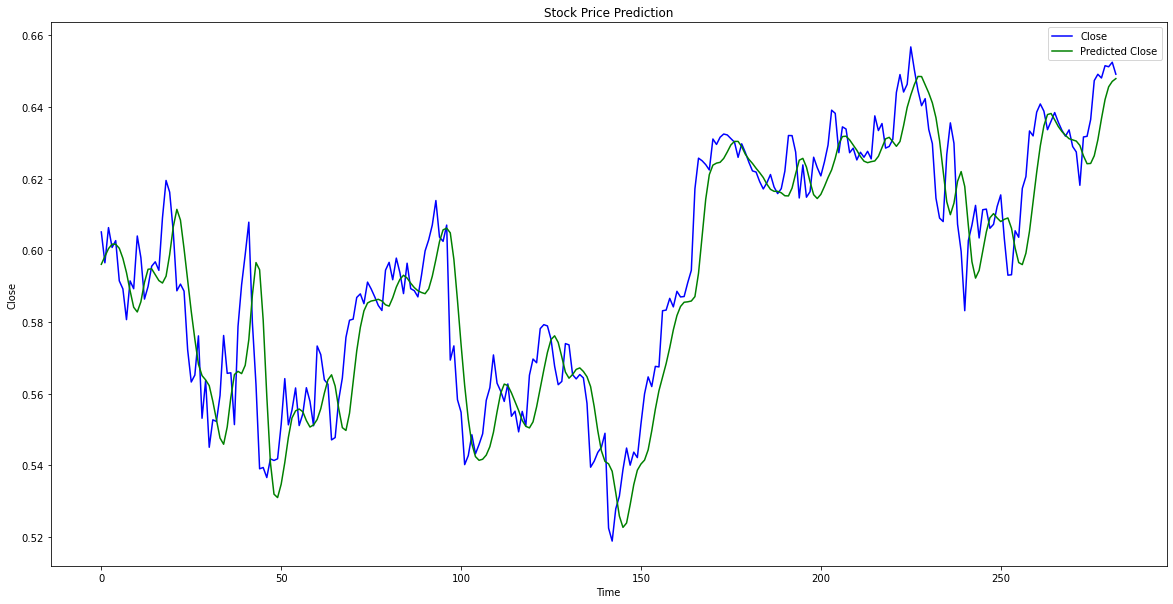

In [15]:
#Test set actual vs predicted
#int(n*0.7)+time_step
real_close_value_test = normalized_df.iloc[ int(n*0.9)+time_step: , close_value_col_index:close_value_col_index+1].values
plot_versus_graph(real_close_value_test, 'blue', 'Close', predicted_close_value_test, 'green', 'Predicted Close')